
In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

Instructions

Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

Read the data into a Pandas dataframe.

Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

Create a logistic regression model to predict this variable from the cleaned data.

Evaluate the results.

In [42]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [110]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
# data = pd.read_sql_query('SELECT * FROM loan', engine)
# data.head()

In [130]:
query = ''' 

WITH n_inventory AS (
SELECT f.film_id, COUNT(i.inventory_id) n_inventory
FROM film f
LEFT JOIN inventory i
ON f.film_id = i.film_id
GROUP BY film_id),

n_rentals AS (
SELECT f.film_id, COUNT(r.rental_id) n_rental,
CASE WHEN r.rental_date BETWEEN '2005-01-01' AND '2006-02-14' THEN 1
    ELSE 0 END AS time_movies_rented
FROM film f
LEFT JOIN inventory i
ON f.film_id = i.film_id
JOIN rental r
ON i.inventory_id = r.inventory_id
GROUP BY film_id,3),

x AS (
SELECT DISTINCT i.film_id, i.n_inventory, r.n_rental, c.name category, f.rating, f.length, f.title movie, f.release_year, f.rental_rate, r.time_movies_rented
FROM n_inventory i
LEFT JOIN n_rentals r
ON i.film_id = r.film_id
JOIN film_category fc
ON i.film_id = fc.film_id
JOIN category c
ON c.category_id = fc.category_id
JOIN film f
ON i.film_id = f.film_id
JOIN inventory inv
ON i.film_id = inv.film_id
JOIN rental r
ON r.inventory_id = inv.inventory_id),

y AS (SELECT RANK() OVER (PARTITION BY film_id ORDER BY time_movies_rented) AS x, film_id, n_inventory, n_rental, category, rating, length, movie, release_year, rental_rate, time_movies_rented
FROM x)

SELECT film_id, n_inventory, n_rental, category, rating, length, movie, release_year, rental_rate, time_movies_rented
FROM y
WHERE x = 1

'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,n_inventory,n_rental,category,rating,length,movie,release_year,rental_rate,time_movies_rented
0,1,8,1,Documentary,PG,86,ACADEMY DINOSAUR,2006,0.99,0
1,2,3,1,Horror,G,48,ACE GOLDFINGER,2006,4.99,0
2,3,4,12,Documentary,NC-17,50,ADAPTATION HOLES,2006,2.99,1
3,4,7,1,Horror,G,117,AFFAIR PREJUDICE,2006,2.99,0
4,5,3,1,Family,G,130,AFRICAN EGG,2006,2.99,0


In [131]:
data.set_index('film_id')

,n_inventory,n_rental,category,rating,length,movie,release_year,rental_rate,time_movies_rented
film_id,,,,,,,,,
1,8,1,Documentary,PG,86,ACADEMY DINOSAUR,2006,0.99,0
2,3,1,Horror,G,48,ACE GOLDFINGER,2006,4.99,0
3,4,12,Documentary,NC-17,50,ADAPTATION HOLES,2006,2.99,1
4,7,1,Horror,G,117,AFFAIR PREJUDICE,2006,2.99,0
5,3,1,Family,G,130,AFRICAN EGG,2006,2.99,0
...,...,...,...,...,...,...,...,...,...
996,2,7,Documentary,G,183,YOUNG LANGUAGE,2006,0.99,1
997,2,6,Music,NC-17,179,YOUTH KICK,2006,0.99,1
998,2,1,Horror,NC-17,105,ZHIVAGO CORE,2006,0.99,0


In [132]:
data.shape

(958, 10)

In [133]:
data.dtypes

film_id                 int64
n_inventory             int64
n_rental                int64
category               object
rating                 object
length                  int64
movie                  object
release_year            int64
rental_rate           float64
time_movies_rented      int64
dtype: object

In [134]:
data.isna().sum()

film_id               0
n_inventory           0
n_rental              0
category              0
rating                0
length                0
movie                 0
release_year          0
rental_rate           0
time_movies_rented    0
dtype: int64

In [135]:
#data.time_movies_rented = data.time_movies_rented.astype(bool)

In [136]:
data.dtypes

film_id                 int64
n_inventory             int64
n_rental                int64
category               object
rating                 object
length                  int64
movie                  object
release_year            int64
rental_rate           float64
time_movies_rented      int64
dtype: object

In [137]:
# getting correlations matrix

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

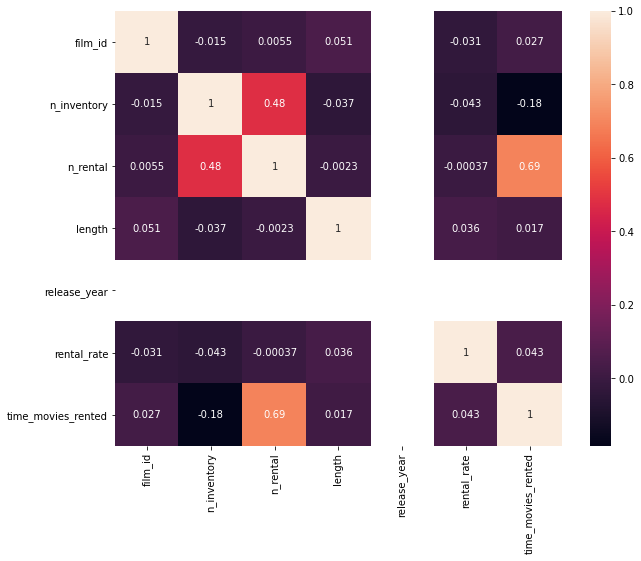

In [139]:
corr_matrix = data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [140]:
# Preprocessing

In [141]:
data.head()

,film_id,n_inventory,n_rental,category,rating,length,movie,release_year,rental_rate,time_movies_rented
0,1,8,1,Documentary,PG,86,ACADEMY DINOSAUR,2006,0.99,0
1,2,3,1,Horror,G,48,ACE GOLDFINGER,2006,4.99,0
2,3,4,12,Documentary,NC-17,50,ADAPTATION HOLES,2006,2.99,1
3,4,7,1,Horror,G,117,AFFAIR PREJUDICE,2006,2.99,0
4,5,3,1,Family,G,130,AFRICAN EGG,2006,2.99,0


In [142]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = data.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

In [143]:
# Dummyfiing Categoricals

In [144]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['movie'], axis=1)
categorical = pd.get_dummies(cat, columns=['category', 'rating'])

In [145]:
categorical.head()

,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,...,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [146]:
# train test split

In [147]:
y = data['time_movies_rented']
data.drop(data[['time_movies_rented']], axis = 1, inplace = True)
X = np.concatenate((x, categorical), axis=1)

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [149]:
y.value_counts()

1    789
0    169
Name: time_movies_rented, dtype: int64

In [150]:
data.head()

,film_id,n_inventory,n_rental,category,rating,length,movie,release_year,rental_rate
0,1,8,1,Documentary,PG,86,ACADEMY DINOSAUR,2006,0.99
1,2,3,1,Horror,G,48,ACE GOLDFINGER,2006,4.99
2,3,4,12,Documentary,NC-17,50,ADAPTATION HOLES,2006,2.99
3,4,7,1,Horror,G,117,AFFAIR PREJUDICE,2006,2.99
4,5,3,1,Family,G,130,AFRICAN EGG,2006,2.99


In [151]:
# train the model

In [152]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [153]:
# validating the model

In [154]:
print("The accuracy of the model in the TEST set is: ", round(classification.score(X_test, y_test),2))

The accuracy of the model in the TEST set is:  0.82


In [155]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.8229166666666666

In [156]:
y_test.value_counts()

1    237
0     51
Name: time_movies_rented, dtype: int64

In [157]:
# getting confussion matrix

In [158]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, predictions)

array([[  0,  51],
       [  0, 237]])

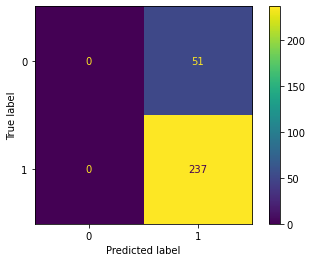

In [159]:
plot_confusion_matrix(classification, X_test, y_test)

In [160]:
# Getting the probabilities of belonging to a particular class

In [161]:
classification.predict_proba(X_test)

array([[0.1746787 , 0.8253213 ],
       [0.18109394, 0.81890606],
       [0.11732617, 0.88267383],
       [0.10534831, 0.89465169],
       [0.17799559, 0.82200441],
       [0.21408787, 0.78591213],
       [0.09536261, 0.90463739],
       [0.14168353, 0.85831647],
       [0.22439948, 0.77560052],
       [0.16404792, 0.83595208],
       [0.21224534, 0.78775466],
       [0.19400209, 0.80599791],
       [0.19404131, 0.80595869],
       [0.24584322, 0.75415678],
       [0.1352536 , 0.8647464 ],
       [0.26602249, 0.73397751],
       [0.10261039, 0.89738961],
       [0.11531144, 0.88468856],
       [0.1073754 , 0.8926246 ],
       [0.13568742, 0.86431258],
       [0.19680612, 0.80319388],
       [0.14750319, 0.85249681],
       [0.11092534, 0.88907466],
       [0.10914677, 0.89085323],
       [0.14280448, 0.85719552],
       [0.14963161, 0.85036839],
       [0.0959945 , 0.9040055 ],
       [0.26766723, 0.73233277],
       [0.15035534, 0.84964466],
       [0.26908636, 0.73091364],
       [0.

In [162]:
classification.predict_proba(X_test)[::,0]

array([0.1746787 , 0.18109394, 0.11732617, 0.10534831, 0.17799559,
       0.21408787, 0.09536261, 0.14168353, 0.22439948, 0.16404792,
       0.21224534, 0.19400209, 0.19404131, 0.24584322, 0.1352536 ,
       0.26602249, 0.10261039, 0.11531144, 0.1073754 , 0.13568742,
       0.19680612, 0.14750319, 0.11092534, 0.10914677, 0.14280448,
       0.14963161, 0.0959945 , 0.26766723, 0.15035534, 0.26908636,
       0.20508091, 0.22335652, 0.09354228, 0.16141772, 0.18803385,
       0.19529816, 0.09723878, 0.11979797, 0.2496892 , 0.23166972,
       0.11665855, 0.19837127, 0.18341183, 0.20448496, 0.28289875,
       0.21745311, 0.09528427, 0.12863903, 0.21795371, 0.22181224,
       0.12826121, 0.16442736, 0.20448947, 0.16955863, 0.24796897,
       0.14195225, 0.09515769, 0.15848259, 0.16529287, 0.22420605,
       0.14864238, 0.243966  , 0.10853009, 0.14536934, 0.14103228,
       0.17864188, 0.14563123, 0.13743363, 0.20956852, 0.09103419,
       0.11174221, 0.14060997, 0.14294235, 0.17328323, 0.14297